# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

%matplotlib inline
from matplotlib import pyplot as plt

#plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("./human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt")
y_train = np.loadtxt(
    "./human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt").astype(int)

X_test = np.loadtxt("./human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt(
    "./human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt").astype(int)

In [5]:
# Проверим размерности
assert (X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert (X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [6]:
# Ваш код здесь
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Определим число уникальных значений меток целевого класса.

In [7]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [8]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [13]:
pca = PCA(0.90, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

182


**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- 65 - ответ
- 66
- 193

In [11]:
print(pca.n_components_)

65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- 51 - ответ
- 56
- 61

In [16]:
print(f"Ответ: {round(pca.explained_variance_ratio_[0] * 100)}%")

Ответ: 51%


Визуализируйте данные в проекции на первые две главные компоненты.

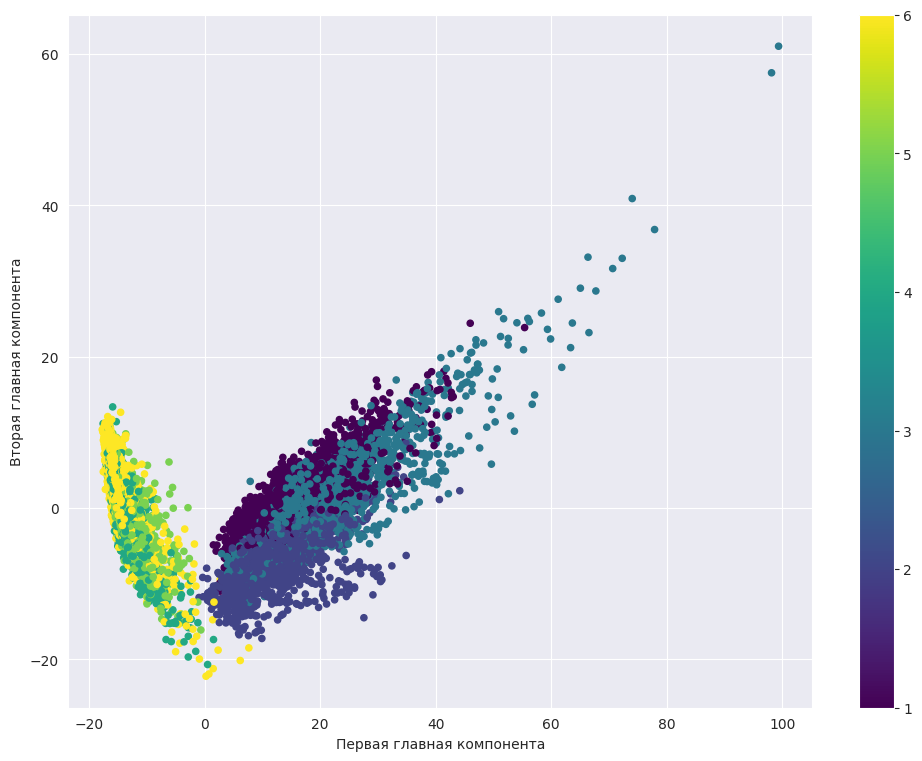

In [19]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')
plt.colorbar()
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.show()

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание) - ответ
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [32]:
# Готовое
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
cluster_labels = kmeans.fit_predict(X_pca)
cluster_labels

array([0, 0, 0, ..., 1, 1, 1], shape=(10299,), dtype=int32)

In [46]:
import numpy as np


class MyKMeans:
    def __init__(self, n_clusters: int, n_init: int = 100,
                 random_state: int = 42, max_iter: int = 242, tol: float = 1e-4):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

        # Параметры модели
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.n_iter_ = None

    def _initialize_centroids(self, X: np.ndarray) -> np.ndarray:
        rng = np.random.default_rng(self.random_state)
        n_samples, _ = X.shape

        # Выбираем первый центроид случайно
        centers = [X[rng.integers(n_samples)]]

        # K-Means++ инициализация
        for _ in range(1, self.n_clusters):
            # Векторизированный расчет квадрата расстояния до ближайшего центроида
            # (N_samples, N_current_centers, N_features)
            all_dists = np.linalg.norm(X[:, np.newaxis] - np.array(centers), axis=2) ** 2
            min_dists = np.min(all_dists, axis=1)

            # Выбор следующего с вероятностью, пропорциональной квадрату расстояния
            probs = min_dists / np.sum(min_dists)
            next_center_idx = rng.choice(n_samples, p=probs)
            centers.append(X[next_center_idx])

        return np.array(centers)

    def _compute_inertia(self, X: np.ndarray, labels: np.ndarray, centers: np.ndarray) -> float:
        # Векторизированный подсчет инерции без явного цикла
        sorted_centers = centers[labels]
        squared_errors = np.sum((X - sorted_centers) ** 2, axis=1)
        return np.sum(squared_errors)

    def _single_run(self, X: np.ndarray, initial_centers: np.ndarray):
        centers = initial_centers.copy()
        loss_prev = np.inf
        rng = np.random.default_rng(self.random_state)

        for it in range(self.max_iter):
            # Шаг 1: Присвоение меток (E-step)
            # Используем broadcasting: (samples, 1, features) - (1, clusters, features)
            dists = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
            labels = np.argmin(dists, axis=1)

            # Шаг 2: Обновление центров (M-step)
            centers_new = np.zeros_like(centers)

            for k in range(self.n_clusters):
                mask = (labels == k)
                if np.any(mask):
                    centers_new[k] = np.mean(X[mask], axis=0)
                else:
                    # Обработка пустого кластера: берем случайную точку
                    centers_new[k] = X[rng.integers(len(X))]

            # Проверка сходимости
            current_inertia = self._compute_inertia(X, labels, centers_new)

            if np.abs(loss_prev - current_inertia) < self.tol:
                return centers_new, labels, current_inertia, it + 1

            centers = centers_new
            loss_prev = current_inertia

        return centers, labels, loss_prev, self.max_iter

    def fit(self, X, y=None):
        data = np.array(X)
        if data.shape[0] < self.n_clusters:
            raise ValueError(f"Число образцов ({data.shape[0]}) меньше числа кластеров ({self.n_clusters}).")

        best_result = {
            'inertia': np.inf,
            'centers': None,
            'labels': None,
            'iter': 0
        }

        # Запускаем алгоритм n_init раз
        for _ in range(self.n_init):
            start_centers = self._initialize_centroids(data)
            c, l, val, it = self._single_run(data, start_centers)

            if val < best_result['inertia']:
                best_result.update({
                    'inertia': val,
                    'centers': c,
                    'labels': l,
                    'iter': it
                })

        # Сохраняем лучшие параметры
        self.cluster_centers_ = best_result['centers']
        self.labels_ = best_result['labels']
        self.inertia_ = best_result['inertia']
        self.n_iter_ = best_result['iter']

        return self

    def predict(self, X):
        if self.cluster_centers_ is None:
            raise ValueError("Сначала обучите модель методом .fit()")

        data = np.array(X)
        # Векторизированное вычисление расстояний до центроидов
        diff = data[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :]
        sq_dists = np.sum(diff ** 2, axis=2)

        return np.argmin(sq_dists, axis=1)

    def score(self, X):
        data = np.array(X)
        pred_labels = self.predict(data)
        return self._compute_inertia(data, pred_labels, self.cluster_centers_)

    def fit_predict(self, X, y=None):
        return self.fit(X, y).labels_

In [39]:
my_kmeans = MyKMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
my_kmeans.fit(X_pca)

mylables = my_kmeans.labels_
centers = my_kmeans.cluster_centers_
inertia = my_kmeans.inertia_

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

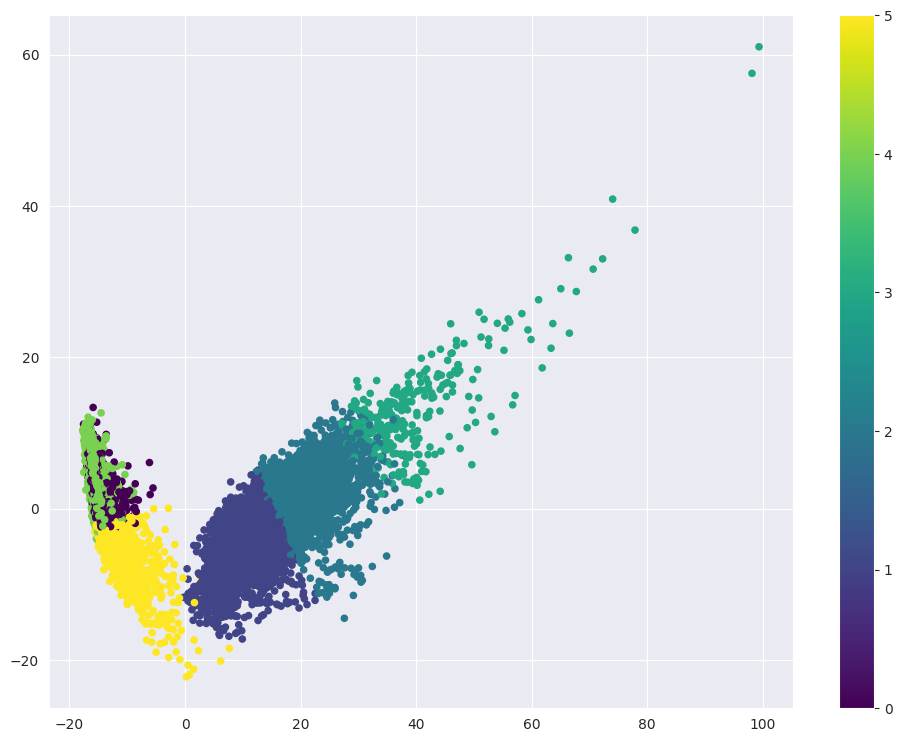

In [24]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis')
plt.colorbar()

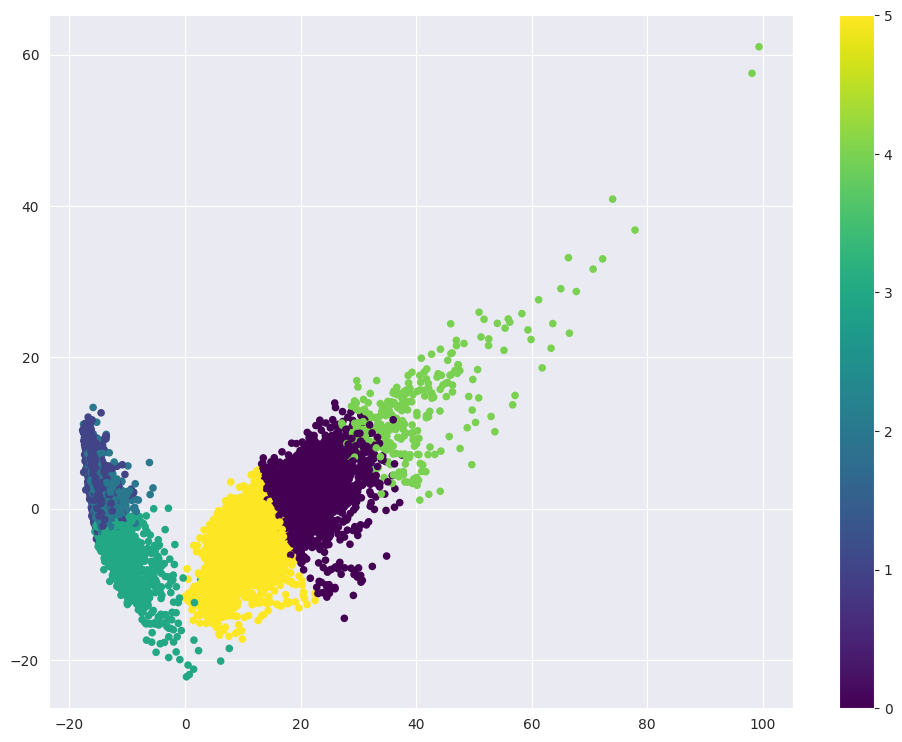

In [35]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=mylables, s=20, cmap='viridis')
plt.colorbar()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [41]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,742,77,0,0,1722
подъем вверх по лестнице,0,1242,295,5,0,2,1544
спуск по лестнице,0,321,889,196,0,0,1406
сидение,1234,1,0,0,91,451,1777
стояние,1340,0,0,0,0,566,1906
лежание,53,5,0,0,1556,330,1944
все,2627,2472,1926,278,1647,1349,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

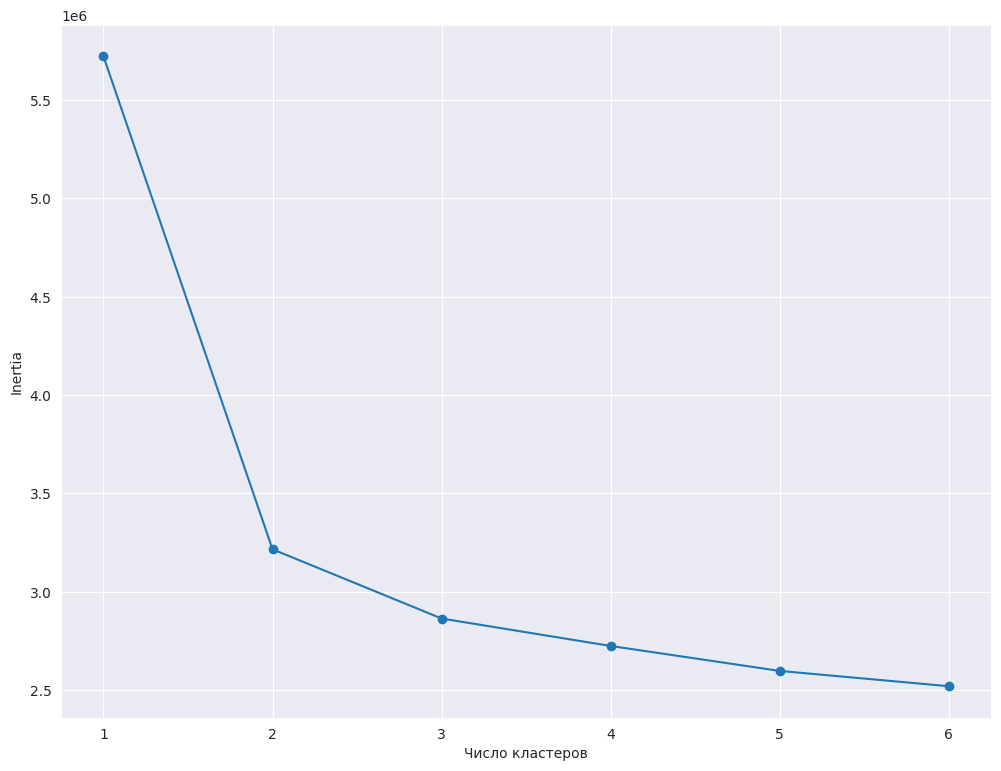

In [49]:
inertia = []
for k in range(1, n_classes + 1):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 9))
plt.plot(range(1, n_classes + 1), inertia, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Inertia')
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2 - ответ
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [50]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [51]:
from sklearn.metrics import adjusted_rand_score

print(f"ARI: {adjusted_rand_score(y, ag.labels_)}")
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
print(f"KMeans: {adjusted_rand_score(y, kmeans.labels_)}")

ARI: 0.4690544575227299
KMeans: 0.419224271062724


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering - ответ
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры - ответ
- В случае случайного разбиения на кластеры ARI будет близок к нулю - ответ

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [53]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [54]:
grid = GridSearchCV(estimator=svc, param_grid=svc_params, cv=3, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

,estimator,LinearSVC(random_state=17)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [60]:
best_svc = grid.best_estimator_

print(grid.best_params_)

tmp = grid.best_score_

{'C': 0.1}


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1 - ответ
- 1
- 10

In [57]:
y_predicted = best_svc.predict(X_test_scaled)

In [58]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,479,11,4,2,0,0,496
подъем вверх по лестнице,4,465,1,1,0,0,471
спуск по лестнице,1,2,416,1,0,0,420
сидение,0,4,0,433,52,2,491
стояние,0,0,0,16,516,0,532
лежание,0,0,0,0,7,530,537
все,484,482,421,453,575,532,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние ---- ответ

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

In [61]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [62]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [63]:
grid = GridSearchCV(estimator=svc, param_grid=svc_params, cv=3, n_jobs=-1)
grid.fit(X_train_pca, y_train)

,estimator,LinearSVC(random_state=17)
,param_grid,"{'C': [0.001, 0.01, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% - ответ
- 10%
- 20%


In [64]:
print(f"{round(abs(tmp - grid.best_score_) * 100)}%")

4%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность - ответ
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком - ответ

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

In [67]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
X_tsne = tsne.fit_transform(X_pca)

dbs = DBSCAN(eps=4.2, min_samples=5)
X_dbs = dbs.fit_predict(X_pca)

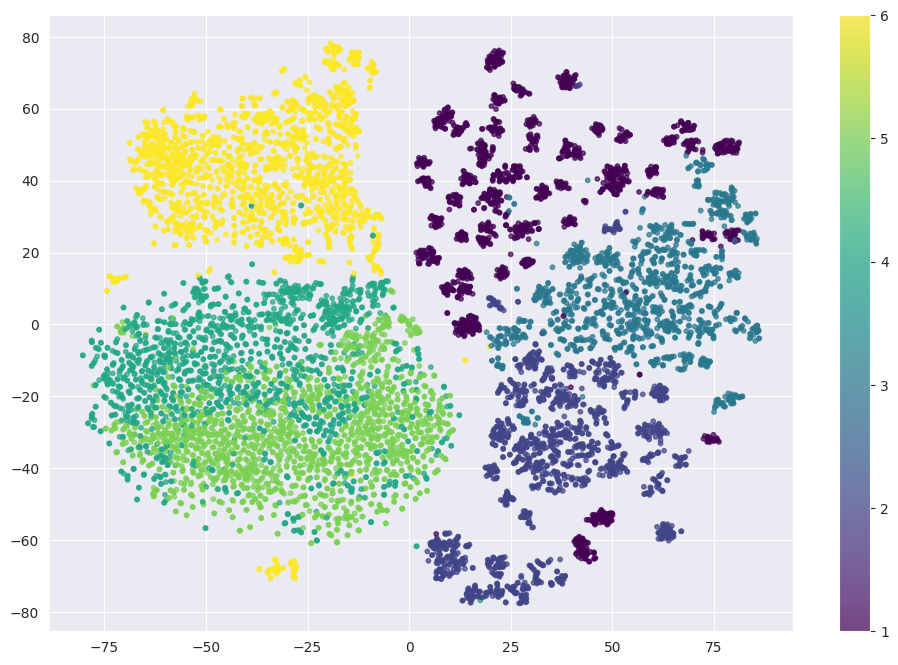

In [76]:
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=10, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.show()